In [5]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from easydict import EasyDict as edict

%matplotlib inline

In [119]:
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict as ddict
from pprint import pprint

In [7]:
def sortdir(f):
    num = f.name.split("_")[-2].split("p")[-1]
    num = int(num)
    return  num

def sortf(f):
    num = f.name.split(".")[0]
    num = int(num)
    return num

In [8]:
def load_pkl(f):
    with open(f, "rb") as fi:
        data = pickle.load(fi)
    return data

## To obtaining simple format file

In [37]:
def parse_sresult(datum):
    res = {
        "JEF"  : datum["jef"]["theta"],
        "FULL": datum["full"]["theta"],
        "UIPD" : datum["UIPD"]["thetah"],
        "UIPJS": datum["UIPJS"]["thetah"],
        "NPP"  : datum["NPP"]["thetah"],
        "LCP"  : datum["LCP"]["thetah"],
        "rMAP" : datum["rMAP"]["thetaP"]
    }
    return res

def save_data(cdir):
    files = list(cdir.glob("*.pkl"))
    files = sorted(files, key=sortf, reverse=False)
    retres = {
        "JEF":[],
        "FULL":[],
        "LCP":[],
        "NPP":[],
        "UIPJS":[],
        "UIPD":[],
        "rMAP":[]
    }
    for fil in tqdm(files):
        datum = load_pkl(fil)
        simdatum = parse_sresult(datum)
        retres["JEF"].append(simdatum["JEF"])
        retres["FULL"].append(simdatum["FULL"])
        retres["UIPD"].append(simdatum["UIPD"])
        retres["UIPJS"].append(simdatum["UIPJS"])
        retres["NPP"].append(simdatum["NPP"])
        retres["LCP"].append(simdatum["LCP"])
        retres["rMAP"].append(simdatum["rMAP"])
    return retres

### Obain the folders

In [42]:
n = 120

root = Path(f"./results/")
dirs = root.glob(f"BiostatR1*_n{n}")
dirs = list(dirs)

### Get the current data

In [150]:
theta0 = 0.2

idxs = np.array([sortdir(d) for d in dirs])/100
idxs = list(np.sort(idxs))

dirs = sorted(dirs, key=sortdir, reverse=False)
cdir = dirs[idxs.index(theta0)]

simData = root/f"./SimBiostatR1_p{sortdir(cdir)}_n{n}.pkl"

### Obtain the cleaned data

In [151]:
if simData.exists():
    cleanData = load_pkl(simData)
else:
    cleanData = save_data(cdir)
    with open(simData, "wb") as f:
        pickle.dump(cleanData, f)

In [152]:
cleanData = edict(cleanData)

### Obtain the mean and variance and MSE from the posterior sample

In [153]:
def ObtainMSE(data, theta0):
    res = ddict(dict)
    for key in data.keys():
        datum = np.squeeze(np.array(data[key]))
        res[key]["Bias"] = np.mean(datum-theta0, axis=1)
        res[key]["Var"] = np.var(datum, axis=1)
        res[key]["MSE"] = np.mean((datum-theta0)**2, axis=1)
    return res

In [154]:
res = ObtainMSE(cleanData, theta0)

In [155]:
Biass = ddict()
for key in res.keys():
    Biass[key] = res[key]["Bias"]
BiasDF = pd.DataFrame(Biass)

In [156]:
Vars = ddict()
for key in res.keys():
    Vars[key] = res[key]["Var"]
VarDF = pd.DataFrame(Vars)

In [157]:
MSEs = ddict()
for key in res.keys():
    MSEs[key] = res[key]["MSE"]
MSEDF = pd.DataFrame(MSEs)

###  bias plot

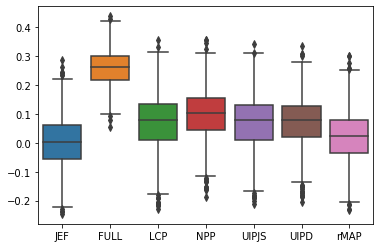

In [158]:
sns.boxplot(data=BiasDF)

In [159]:
BiasDF.mean()

JEF      0.002343
FULL     0.259766
LCP      0.067807
NPP      0.097772
UIPJS    0.067741
UIPD     0.070750
rMAP     0.021823
dtype: float64

### var plot

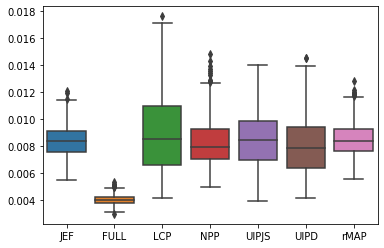

In [160]:
sns.boxplot(data=VarDF)

In [161]:
VarDF.mean()

JEF      0.008391
FULL     0.004039
LCP      0.008932
NPP      0.008285
UIPJS    0.008473
UIPD     0.007992
rMAP     0.008514
dtype: float64

### MSE plot

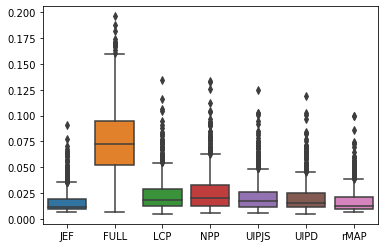

In [162]:
sns.boxplot(data=MSEDF)

#### MSE no full

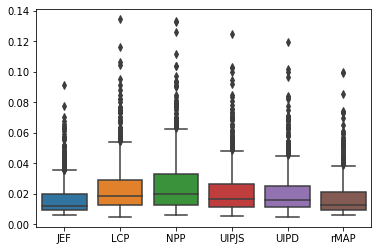

In [163]:
sns.boxplot(data=MSEDF.iloc[:, [0, 2, 3, 4, 5, 6]])

In [164]:
MSEDF.mean()

JEF      0.016561
FULL     0.075280
LCP      0.023497
NPP      0.025877
UIPJS    0.021756
UIPD     0.020763
rMAP     0.017268
dtype: float64